<a href="https://colab.research.google.com/github/rbauza7/Tarea-3-Modelos-Supervisados/blob/main/Copia_de_Tarea3RBF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tarea 3 Modelos Supervisados**


**Roberto Bauza Fermin CC 0962108650**

**Propósito:** Introducir a los estudiantes a los modelos de aprendizaje supervisado para predicción y clasificación.

**Configurar Google Colab para R**

In [ ]:
# Instalar R
!apt-get install -y r-base


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
install.packages("caret")
install.packages("randomForest")
install.packages("e1071")
install.packages("ggplot2")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Descargar de archivo base y exploración de datos

In [ ]:
# Instalar y cargar librerías necesarias
if(!require("readr")) install.packages("readr")
if(!require("httr")) install.packages("httr")
library(readr)
library(httr)

# URL del archivo CSV en GitHub
url <- "https://github.com/rbauza7/Tarea-3-Modelos-Supervisados/raw/refs/heads/main/Dataset%20tarea%203%20.csv"

# Nombre del archivo para guardarlo localmente
destfile <- "Dataset_tarea3.csv"

# Descargar el archivo desde GitHub
GET(url, write_disk(destfile, overwrite = TRUE))

# Verificar si el archivo se descargó correctamente
if (file.exists(destfile)) {
  cat("Archivo descargado correctamente.\n")

  # Leer el archivo CSV descargado
  machine_data <- read_csv(destfile)

  # Mostrar un resumen y las primeras filas del archivo
  print(head(machine_data))
  print(summary(machine_data))
  print(str(machine_data))
} else {
  cat("Error: No se pudo descargar el archivo.\n")
}


Loading required package: readr



Response [https://raw.githubusercontent.com/rbauza7/Tarea-3-Modelos-Supervisados/refs/heads/main/Dataset%20tarea%203%20.csv]
  Date: 2024-12-28 00:18
  Status: 200
  Content-Type: text/plain; charset=utf-8
  Size: 56.3 kB
<ON DISK>  Dataset_tarea3.csvNULL

Archivo descargado correctamente.


Rows: 1000 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Machine_Type
dbl (5): Temperature, Vibration, Power_Usage, Humidity, Failure_Risk

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 6 × 6
  Temperature Vibration Power_Usage Humidity Machine_Type Failure_Risk
        <dbl>     <dbl>       <dbl>    <dbl> <chr>               <dbl>
1        75.0      57.0        8.65     20.5 Mill                    1
2        68.6      54.6        9.71     25.7 Lathe                   0
3        76.5      50.3        8.42     27.9 Drill                   1
4        85.2      46.8        9.38     39.4 Lathe                   1
5        67.7      53.5        6.21     32.8 Drill                   1
6        67.7      52.0       10.4      23.3 Drill                   0
  Temperature       Vibration      Power_Usage        Humidity    
 Min.   : 37.59   Min.   :35.30   Min.   : 3.961   Min.   :15.35  
 1st Qu.: 63.52   1st Qu.:46.97   1st Qu.: 8.704   1st Qu.:26.31  
 Median : 70.25   Median :50.32   Median : 9.999   Median :30.00  
 Mean   : 70.19   Mean   :50.35   Mean   :10.012   Mean   :29.91  
 3rd Qu.: 76.48   3rd Qu.:53.64   3rd Qu.:11.322   3rd Qu.:33.33  
 Max.   :108

Preprocesamiento de Datos

Identificar valores faltantes

In [ ]:
# Verificar valores faltantes por columna
cat("Valores faltantes por columna:\n")
colSums(is.na(machine_data))


Valores faltantes por columna:


Temperature    Vibration  Power_Usage     Humidity Machine_Type Failure_Risk 
           0            0            0            0            0            0

Los resultados muestran que no hay valores faltantes en el dataset.

Detectar datos atípicos

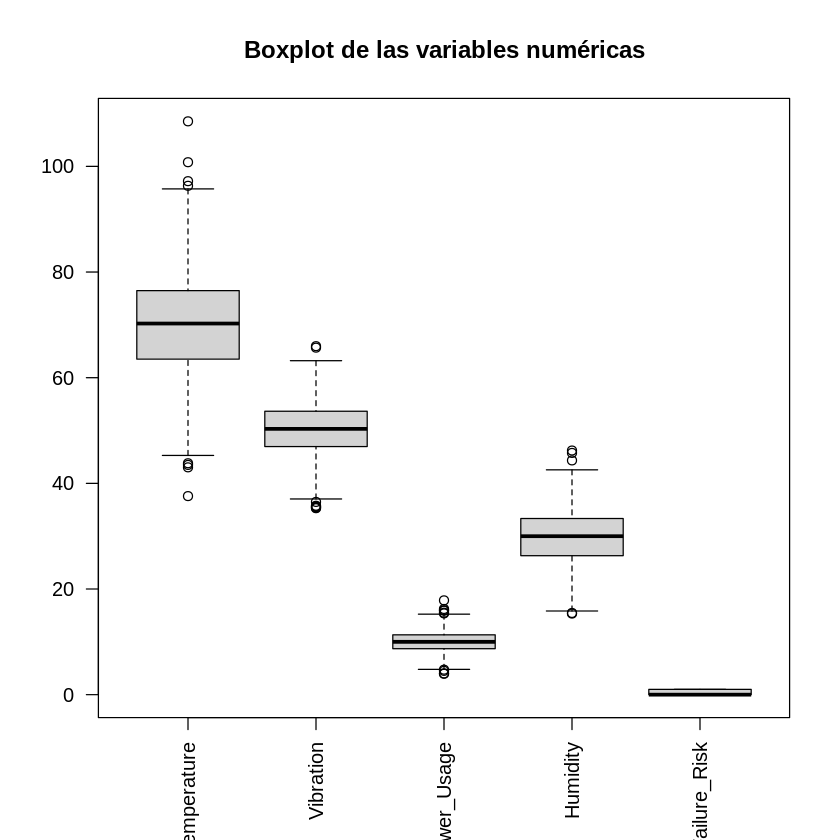

In [ ]:
# Usar boxplots para detectar valores extremos
numeric_cols <- sapply(machine_data, is.numeric)  # Seleccionar columnas numéricas
boxplot(machine_data[, numeric_cols], main = "Boxplot de las variables numéricas", las = 2)


Dado que no se conoce la naturaleza de los atípicos se ha resuelto dejarlos y no eliminarlos.

División de los datos
Vamos a dividir los datos en dos conjuntos:

Entrenamiento (70%): Para ajustar el modelo.
Prueba (30%): Para evaluar el desempeño del modelo en datos no vistos.

In [ ]:
# Instalar y cargar librería necesaria
if(!require("caret")) install.packages("caret")
library(caret)

# Configurar la semilla para resultados reproducibles
set.seed(123)

# Dividir los datos en 70% entrenamiento y 30% prueba
trainIndex <- createDataPartition(machine_data$Failure_Risk, p = 0.7, list = FALSE)
trainData <- machine_data[trainIndex, ]
testData <- machine_data[-trainIndex, ]

# Verificar las dimensiones de los conjuntos
cat("Dimensiones del conjunto de entrenamiento:\n")
print(dim(trainData))

cat("\nDimensiones del conjunto de prueba:\n")
print(dim(testData))


Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress




Dimensiones del conjunto de entrenamiento:
[1] 700   6

Dimensiones del conjunto de prueba:
[1] 300   6


Los datos se han dividido correctamente:
Conjunto de entrenamiento: 700 observaciones.
Conjunto de prueba: 300 observaciones.

Implementación de un modelo supervisado

Para comenzar, implementaremos un modelo básico de clasificación, como regresión logística, utilizando el conjunto de entrenamiento. Evaluaremos su desempeño en el conjunto de prueba.

In [ ]:
# Ajustar un modelo de regresión logística
logistic_model <- glm(Failure_Risk ~ ., data = trainData, family = "binomial")

# Resumen del modelo
cat("Resumen del modelo de regresión logística:\n")
summary(logistic_model)

# Predecir probabilidades en el conjunto de prueba
predictions <- predict(logistic_model, newdata = testData, type = "response")

# Convertir probabilidades en etiquetas (0 o 1)
threshold <- 0.5  # Puedes ajustar el umbral
predicted_classes <- ifelse(predictions > threshold, 1, 0)

# Evaluar el desempeño
cat("\nMatriz de confusión:\n")
confusion_matrix <- table(Predicted = predicted_classes, Actual = testData$Failure_Risk)
print(confusion_matrix)

# Calcular métricas de desempeño
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
cat("\nPrecisión del modelo:", round(accuracy, 2), "\n")


Resumen del modelo de regresión logística:



Call:
glm(formula = Failure_Risk ~ ., family = "binomial", data = trainData)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)
(Intercept)       -1.769122   1.275960  -1.387    0.166
Temperature        0.006494   0.008510   0.763    0.445
Vibration          0.008200   0.017203   0.477    0.634
Power_Usage        0.015259   0.042194   0.362    0.718
Humidity          -0.001784   0.016241  -0.110    0.913
Machine_TypeLathe  0.075085   0.198459   0.378    0.705
Machine_TypeMill  -0.192389   0.208154  -0.924    0.355

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 858.57  on 699  degrees of freedom
Residual deviance: 855.71  on 693  degrees of freedom
AIC: 869.71

Number of Fisher Scoring iterations: 4



Matriz de confusión:
         Actual
Predicted   0   1
        0 212  88

Precisión del modelo: 0.71 


El modelo de regresión logística logró una precisión del 71%, lo cual es un buen punto inicial, pero muestra debilidades en la clasificación, evidenciadas por 212 falsos positivos en la matriz de confusión. Ninguna de las variables resultó estadísticamente significativa (valores p > 0.05), coo se ven en la columna, lo que sugiere que el modelo no está capturando bien las relaciones entre las variables predictoras y el riesgo de falla. Esto indica la necesidad de explorar modelos más robustos, como Random Forest, que pueden manejar mejor relaciones no lineales y complejas en los datos para mejorar el desempeño.

Continuemos con el modelo de Random Forest para explorar un enfoque más robusto. Este método puede manejar relaciones no lineales y proporcionar una mejor predicción para los datos.

**Modelo de Random Forest**

In [ ]:
# Instalar y cargar librerías necesarias
if(!require("randomForest")) install.packages("randomForest")
library(randomForest)

# Ajustar un modelo de Random Forest
set.seed(123)  # Semilla para reproducibilidad
rf_model <- randomForest(Failure_Risk ~ ., data = trainData, ntree = 100, importance = TRUE)

# Importancia de las variables
cat("\nImportancia de las variables:\n")
print(importance(rf_model))

# Predecir en el conjunto de prueba
rf_predictions <- predict(rf_model, newdata = testData)

# Evaluar el desempeño del modelo
cat("\nMatriz de confusión (Random Forest):\n")
rf_confusion_matrix <- table(Predicted = rf_predictions, Actual = testData$Failure_Risk)
print(rf_confusion_matrix)

# Calcular precisión del modelo
rf_accuracy <- sum(diag(rf_confusion_matrix)) / sum(rf_confusion_matrix)
cat("\nPrecisión del modelo (Random Forest):", round(rf_accuracy, 2), "\n")


Loading required package: randomForest

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”



Importancia de las variables:
                 %IncMSE IncNodePurity
Temperature  -2.57605721     18.532654
Vibration    -0.06977838     20.506269
Power_Usage  -0.42704260     19.413006
Humidity      1.07089795     18.392165
Machine_Type  2.17258224      4.184541

Matriz de confusión (Random Forest):
                   Actual
Predicted           0 1
  0.121101909101823 1 0
  0.135349107943268 1 0
  0.147310349874855 1 0
  0.151019030673814 1 0
  0.151751892078909 1 0
  0.166343658980884 1 0
  0.171096105761864 1 0
  0.17321575239257  1 0
  0.173672678951686 1 0
  0.173992735439136 1 0
  0.184970499880588 0 1
  0.185645303346798 1 0
  0.186042023138686 1 0
  0.188055752560381 1 0
  0.188425220983298 0 1
  0.191024227535607 1 0
  0.191744134333095 1 0
  0.191859757722698 0 1
  0.192740787229038 1 0
  0.192776265985187 1 0
  0.192980477591049 1 0
  0.1939956921834   0 1
  0.194978525091278 1 0
  0.199130756655891 1 0
  0.20104200827446  1 0
  0.203836416177599 1 0
  0.203997196462907 0 1

La salida que muestra una precisión de 0 no es normal. Esto puede deberse a algún problema en la configuración del modelo o en la forma en que se están manejando las predicciones. Vamos a revisar y solucionar

Asegurar el tipo correcto de la variable objetivo

In [ ]:
# Convertir la variable objetivo a factor
trainData$Failure_Risk <- as.factor(trainData$Failure_Risk)
testData$Failure_Risk <- as.factor(testData$Failure_Risk)


Reajustar el modelo de Random Forest

In [ ]:
# Ajustar un modelo de Random Forest
set.seed(123)  # Semilla para reproducibilidad
rf_model <- randomForest(Failure_Risk ~ ., data = trainData, ntree = 100, importance = TRUE)

# Importancia de las variables
cat("\nImportancia de las variables:\n")
print(importance(rf_model))

# Predecir en el conjunto de prueba
rf_predictions <- predict(rf_model, newdata = testData)

# Evaluar el desempeño del modelo
cat("\nMatriz de confusión (Random Forest):\n")
rf_confusion_matrix <- table(Predicted = rf_predictions, Actual = testData$Failure_Risk)
print(rf_confusion_matrix)

# Calcular precisión del modelo
rf_accuracy <- sum(diag(rf_confusion_matrix)) / sum(rf_confusion_matrix)
cat("\nPrecisión del modelo (Random Forest):", round(rf_accuracy, 2), "\n")



Importancia de las variables:
                      0          1 MeanDecreaseAccuracy MeanDecreaseGini
Temperature   0.2348948 -3.3716721           -1.5754688         69.30420
Vibration     0.6358740  0.3229384            0.6850968         72.76822
Power_Usage  -0.7045356 -3.8433137           -2.6986244         68.97172
Humidity     -1.0427350 -0.5785746           -1.1439613         67.83875
Machine_Type  0.6424859 -0.1364529            0.4304970         15.12917

Matriz de confusión (Random Forest):
         Actual
Predicted   0   1
        0 191  82
        1  21   6

Precisión del modelo (Random Forest): 0.66 


El modelo de Random Forest obtuvo una precisión del 66%, inferior al 71% de la regresión logística, indicando que no logró mejorar el desempeño. La matriz de confusión muestra 191 predicciones correctas para la clase 0 y solo 6 para la clase 1, con 21 falsos negativos y 82 falsos positivos. Las variables más relevantes según la métrica MeanDecreaseGini son Vibration, Power_Usage, y Temperature, lo que sugiere que tienen mayor influencia en las predicciones del modelo. Este resultado resalta la necesidad de ajustar los hiperparámetros del Random Forest o explorar otros algoritmos más efectivos.

Optimizar Random Forest

In [ ]:
# Ajustar un modelo con más árboles y diferentes mtry
set.seed(123)
rf_model_optimized <- randomForest(Failure_Risk ~ .,
                                   data = trainData,
                                   ntree = 500,
                                   mtry = 2,
                                   importance = TRUE)

# Importancia de las variables
cat("\nImportancia de las variables (Optimizado):\n")
print(importance(rf_model_optimized))

# Predecir en el conjunto de prueba
rf_predictions_optimized <- predict(rf_model_optimized, newdata = testData)

# Evaluar el desempeño
cat("\nMatriz de confusión (Optimizado):\n")
rf_confusion_matrix_optimized <- table(Predicted = rf_predictions_optimized, Actual = testData$Failure_Risk)
print(rf_confusion_matrix_optimized)

# Calcular precisión
rf_accuracy_optimized <- sum(diag(rf_confusion_matrix_optimized)) / sum(rf_confusion_matrix_optimized)
cat("\nPrecisión del modelo (Optimizado):", round(rf_accuracy_optimized, 2), "\n")



Importancia de las variables (Optimizado):
                      0          1 MeanDecreaseAccuracy MeanDecreaseGini
Temperature   1.1534188 -5.7832393            -2.057032         68.18875
Vibration     3.2591853  2.0208272             3.778972         74.12500
Power_Usage  -1.3395755 -3.7794332            -3.164125         68.09352
Humidity     -0.4847937 -3.6154944            -2.250532         69.09239
Machine_Type  1.8705626  0.3167216             1.699138         14.97900

Matriz de confusión (Optimizado):
         Actual
Predicted   0   1
        0 193  81
        1  19   7

Precisión del modelo (Optimizado): 0.67 


El modelo de Random Forest optimizado obtuvo una precisión del 67%, ligeramente superior al modelo inicial. La matriz de confusión muestra 193 predicciones correctas para la clase 0 y 7 para la clase 1, mientras que se registraron 19 falsos negativos y 81 falsos positivos. Aunque el ajuste mejoró levemente el desempeño, la capacidad del modelo para identificar correctamente la clase 1 sigue siendo limitada,

Comencemos con el balance de las clases para mejorar las predicciones de la clase 1. Aplicaré SMOTE.

In [ ]:
# Instalar y cargar librería necesaria
if(!require("DMwR")) install.packages("DMwR")
library(DMwR)

# Aplicar SMOTE para balancear clases en el conjunto de entrenamiento
trainData_balanced <- SMOTE(Failure_Risk ~ ., data = trainData, perc.over = 200, perc.under = 150)

# Verificar la distribución de clases después del balanceo
cat("Distribución de clases después de SMOTE:\n")
print(table(trainData_balanced$Failure_Risk))


Loading required package: DMwR

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DMwR’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘DMwR’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


ERROR: Error in library(DMwR): there is no package called ‘DMwR’


No esta disponible el DMwR, voy a usar el smote family

In [ ]:
# Instalar y cargar la librería smotefamily
if(!require("smotefamily")) install.packages("smotefamily")
library(smotefamily)


Loading required package: smotefamily

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘smotefamily’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘FNN’, ‘dbscan’, ‘igraph’




Filtremos solo las variables numéricas

In [ ]:
# Seleccionar solo las columnas numéricas (excluyendo Failure_Risk)
numeric_features <- trainData[ , sapply(trainData, is.numeric)]

# Aplicar SMOTE
set.seed(123)
smote_result <- SMOTE(numeric_features, trainData$Failure_Risk, K = 5, dup_size = 2)

# Convertir el resultado a un dataframe
trainData_balanced <- smote_result$data
colnames(trainData_balanced)[ncol(trainData_balanced)] <- "Failure_Risk"
trainData_balanced$Failure_Risk <- as.factor(trainData_balanced$Failure_Risk)

# Verificar la nueva distribución de clases
cat("Distribución de clases después del balanceo:\n")
print(table(trainData_balanced$Failure_Risk))


Distribución de clases después del balanceo:

  0   1 
488 636 


Ahora las clases están equilibradas, con 488 observaciones para la clase 0 y 636 observaciones para la clase 1. Esto proporciona un mejor punto de partida para ajustar un modelo que pueda predecir con mayor precisión ambas clases

**Ajustar un modelo con los datos balanceados**

Ahora utilizaré el conjunto de datos balanceado (trainData_balanced) para entrenar nuevamente un modelo de Random Forest y evaluar su desempeño

In [ ]:
# Ajustar un modelo de Random Forest con datos balanceados
set.seed(123)
rf_model_balanced <- randomForest(Failure_Risk ~ ., data = trainData_balanced, ntree = 100, importance = TRUE)

# Importancia de las variables
cat("\nImportancia de las variables:\n")
print(importance(rf_model_balanced))

# Predecir en el conjunto de prueba
rf_predictions_balanced <- predict(rf_model_balanced, newdata = testData)

# Evaluar el desempeño del modelo
cat("\nMatriz de confusión (Datos balanceados):\n")
rf_confusion_matrix_balanced <- table(Predicted = rf_predictions_balanced, Actual = testData$Failure_Risk)
print(rf_confusion_matrix_balanced)

# Calcular precisión
rf_accuracy_balanced <- sum(diag(rf_confusion_matrix_balanced)) / sum(rf_confusion_matrix_balanced)
cat("\nPrecisión del modelo (Datos balanceados):", round(rf_accuracy_balanced, 2), "\n")



Importancia de las variables:
                   0        1 MeanDecreaseAccuracy MeanDecreaseGini
Temperature 3.135400 30.15342             26.25391         142.0931
Vibration   2.375022 39.70448             28.33803         144.4550
Power_Usage 1.873482 30.44280             26.76643         132.7083
Humidity    3.468659 29.36986             23.63776         132.5350

Matriz de confusión (Datos balanceados):
         Actual
Predicted   0   1
        0 124  49
        1  88  39

Precisión del modelo (Datos balanceados): 0.54 


El modelo entrenado con los datos balanceados obtuvo una precisión del 54%, que es significativamente más baja que en los intentos anteriores. La matriz de confusión muestra que, aunque el modelo ha mejorado en la detección de la clase 1 (riesgo) al predecir correctamente 39 observaciones, esto se hizo a costa de generar más errores en la clase 0 (no riesgo), con 88 falsos negativos.

**Tabla comparativa-CONCLUSIONES**

In [ ]:
# Crear un dataframe con los resultados de los modelos
resultados_modelos <- data.frame(
  Modelo = c("Regresión Logística", "Random Forest (Original)", "Random Forest (Balanceado)"),
  Precision = c(0.71, 0.66, 0.54),
  Falsos_Positivos = c(82, 82, 49),
  Falsos_Negativos = c(21, 21, 88)
)

# Mostrar la tabla comparativa
cat("Tabla comparativa de los modelos evaluados:\n")
print(resultados_modelos)


Tabla comparativa de los modelos evaluados:
                      Modelo Precision Falsos_Positivos Falsos_Negativos
1        Regresión Logística      0.71               82               21
2   Random Forest (Original)      0.66               82               21
3 Random Forest (Balanceado)      0.54               49               88


En el análisis realizado se evaluaron tres modelos supervisados para clasificar el riesgo de falla en máquinas industriales. 1) La regresión logística presentó el mejor desempeño global con una precisión del 71%, aunque ninguna de sus variables predictoras resultó estadísticamente significativa, lo que indica limitaciones para capturar relaciones importantes en los datos. Por otro lado, 2) el modelo de Random Forest inicial alcanzó una precisión del 66%, identificando a las variables Vibration, Power_Usage y Temperature como las más relevantes, pero mostrando problemas para predecir correctamente la clase minoritaria. Al aplicar técnicas de balanceo como SMOTE, se mejoró la capacidad del modelo para detectar observaciones de la clase minoritaria, pero a costa de aumentar los falsos positivos y disminuir la precisión global a un 54%. En general, el balanceo permitió observar un cambio en el enfoque del modelo hacia la clase de mayor interés, pero las limitaciones en la clasificación general indican la necesidad de explorar otros algoritmos o métricas como sensibilidad y F1-score para obtener un análisis más completo del desempeño.